In [1]:
# import some keras and basic module 

from __future__ import print_function 
import tensorflow.keras as keras

# data set cifar 10 
from tensorflow.keras.datasets import cifar10 

# basic preprocesssing for image data 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# construct neural network 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten 
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers 
from tensorflow.keras import models 
import os 

import numpy as np 

import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model
import tensorflow as tf 

config = tf.ConfigProto()
tf.enable_eager_execution(config=config)

from fmp import *

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
## basic parameters 
batch_size = 40 
num_classes = 10 
num_epochs = 300 
is_data_augmentation = True 
model_dir = 'models'
model_filename = 'model_BeatLeNet5_6_ResNet.h'


In [3]:
def residual_network(x):
    
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)
        
        return y 
    def grouped_convolution(y,nb_channels,_strides):
        if cardinality == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3,3), strides=_strides, padding='same')(y)
        assert not nb_channels % cardinality 
        _d = nb_channels // cardinality 
        
        
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j* _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d,kernel_size=(3,3),strides = _strides, padding = 'same')(group))
            
        y = layers.concatenate(groups)
        
        return y 
    
    def residual_block(y, nb_channels_in,nb_channels_out,_strides = (1,1), _project_shortcut= False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology, 
        and are subject to two simple rules:
        
        - If producing spatial maps of the same size, the blocks share the same 
        
        """
        shortcut = y 
        
        y = layers.Conv2D(nb_channels_in, kernel_size=(1,1) , strides=(1,1) , padding='same')(y)
        y = add_common_layers(y)
        
        y = grouped_convolution(y,nb_channels_in,_strides=_strides)
        y = add_common_layers(y)
        
        y = layers.Conv2D(nb_channels_out,kernel_size=(1,1),strides=(1,1), padding='same')(y)
        
        y = layers.BatchNormalization()(y)
        
        if _project_shortcut or _strides != (1, 1):
            
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1,1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
            
        y = layers.add([shortcut, y])
        
        y = layers.LeakyReLU()(y)
        
        return y 
    
    x = layers.Conv2D(32,kernel_size=(5,5), strides=(1,1), padding='same')(x)
    x = add_common_layers(x)
    
    x = layers.MaxPool2D(pool_size=(2,2), strides=(1,1), padding='same')(x)
    for i in range(3):
        project_shortcut = True if i == 0 else False 
        x = residual_block(x,16,32,_project_shortcut=project_shortcut)
        
        
    for i in range(4): 
        strides = (2,2) if i == 0 else (1,1)
        x = residual_block(x, 32, 64, _strides=strides)
        
    for i in range(6):
        strides = (2,2) if i==0 else (1,1)
        x = residual_block(x, 64, 128, _strides=strides)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(10)(x)
    
    return x 
img_height = 32
img_width = 32 
img_channels = 3 
cardinality = 2
image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
network_output = residual_network(image_tensor)

cnn_model = models.Model(inputs=[image_tensor], outputs=[network_output])

print(cnn_model.summary)
#plot_model(cnn_model, show_shapes=True,to_file='cnn_model.png')

<bound method Network.summary of <tensorflow.python.keras.engine.training.Model object at 0x0000023CC942E708>>


In [4]:
#read data and split data into train and test set

(train_set,train_label),(test_set,test_label) = cifar10.load_data() 

# Convert class label to binary vector 
train_label = keras.utils.to_categorical(train_label,num_classes)
test_label  = keras.utils.to_categorical(test_label,num_classes) 
print(train_label.shape)
print(test_label.shape)
print('the shape of training data set is: ',train_set.shape) 

(50000, 10)
(10000, 10)
the shape of training data set is:  (50000, 32, 32, 3)


In [5]:


# initialization of optimizer 
opt = keras.optimizers.Adadelta(learning_rate=0.1, rho=0.95)

# train the model by optimizer
cnn_model.compile(loss = 'categorical_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])

train_set = train_set.astype('float32')
test_set = test_set.astype('float32') 

train_set /= 255 
test_set /= 255 

if not is_data_augmentation:
    print('Not using data augmentation.')
    cnn_history = cnn_model.fit(train_set, train_label,
              batch_size=batch_size,
              epochs=num_epochs,
              validation_data=(test_set, test_label),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
     
    
    # set parameter for data augmentation 
    data_transform_parameters = {
                                "rotation_range": 15,
                                "width_shift_range":0.1,
                                "height_shift_range":0.1,
                                "horizontal_flip":True
                                }
    
    # get object of augmentation data generator 
    augment_data_set_generator = ImageDataGenerator(data_transform_parameters)    
    
    
    # get augmented data set 
    
    augment_train_set = augment_data_set_generator.apply_transform(train_set,data_transform_parameters)
    print(augment_train_set.shape)
  
    
    # Limit GPU device to the first GPU 
    #gpus = tf.config.experimental.list_physical_devices('GPU')
    #if gpus:
      # Restrict TensorFlow to only use the first GPU
    #  try:
    #    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    #    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    #    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    #  except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
    #    print(e)
        
        
    # train model by GPU 
    with tf.device('/device:GPU:0'):
        cnn_history = cnn_model.fit(augment_train_set, train_label,
                  batch_size=batch_size,
                  epochs=num_epochs,
                  validation_data=(test_set, test_label),
                  shuffle=True)

# save model and weights 
if not os.path.isdir(model_dir): 
    os.makedirs(model_dir) 
model_path = os.path.join(model_dir,model_filename)
cnn_model.save(model_path)
print("CNN Model saved at %s " % model_path)

# Score trained model 

test_loss_value, test_metric_value = cnn_model.evaluate(test_set,test_label,verbose =1 )
train_loss_value, train_metric_value = cnn_model.evaluate(train_set,train_label,verbose =1)


print("Train loss: ", train_loss_value) 
print("Trian metric: ", train_metric_value)

print("Test loss: ", test_loss_value)
print("Test accuracy:", test_metric_value)
# print(cnn_history.history)


Using real-time data augmentation.
(50000, 32, 32, 3)
Train on 50000 samples, validate on 10000 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/300
50000/50000 [==============================] - 94s 2ms/sample - loss: 8.1907 - acc: 0.1115 - val_loss: 7.8846 - val_acc: 0.1056
Epoch 2/300
50000/50000 [==============================] - 87s 2ms/sample - loss: 8.1452 - acc: 0.1121 - val_loss: 8.7704 - val_acc: 0.1168
Epoch 3/300
50000/50000 [==============================] - 87s 2ms/sample - loss: 8.3482 - acc: 0.1151 - val_loss: 8.2451 - val_acc: 0.1070
Epoch 4/300
50000/50000 [==============================] - 87s 2ms/sample - loss: 8.2435 - acc: 0.1109 - val_loss: 8.0909 - val_acc: 0.1128
Epoch 5/300
50000/50000 [==============================] - 87s 2ms/sample - loss: 8.0216 - acc: 0.1189 - val_loss: 7.9105 - val_acc: 0.1129
Epoch 6/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 7.8884 - acc: 0.1208

50000/50000 [==============================] - 86s 2ms/sample - loss: 8.1009 - acc: 0.1363 - val_loss: 7.8451 - val_acc: 0.1227
Epoch 57/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 8.1176 - acc: 0.1248 - val_loss: 8.0151 - val_acc: 0.1160
Epoch 58/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 8.1510 - acc: 0.1190 - val_loss: 8.3683 - val_acc: 0.1193
Epoch 59/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 8.1786 - acc: 0.1127 - val_loss: 9.0768 - val_acc: 0.1104
Epoch 60/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 8.0886 - acc: 0.1224 - val_loss: 8.0827 - val_acc: 0.1112
Epoch 61/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 8.0188 - acc: 0.1073 - val_loss: 7.8545 - val_acc: 0.0867
Epoch 62/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 3.7318 - acc: 0.1007 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 63/300
50000/500

50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 112/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 113/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 114/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 115/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 116/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 117/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val

50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 166/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 167/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 168/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 169/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 170/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 171/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val

Epoch 220/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 221/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 222/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 223/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 224/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 225/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 226/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc

50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 275/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 276/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 277/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 278/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 279/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val_loss: 1.1921e-07 - val_acc: 0.1000
Epoch 280/300
50000/50000 [==============================] - 86s 2ms/sample - loss: 1.1921e-07 - acc: 0.1000 - val

Text(0.5, 1.0, 'test loss and test accuracy')

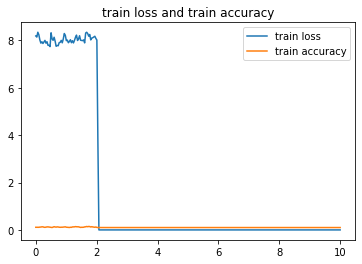

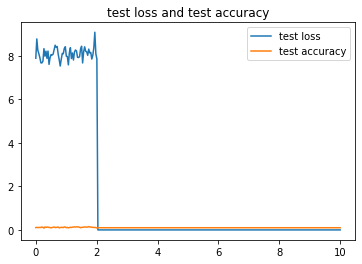

In [6]:

# get history data
epoth_x = np.linspace(0, 10, num_epochs, endpoint=True)
train_loss = cnn_history.history['loss']
train_accuracy = cnn_history.history['acc']
test_loss = cnn_history.history['val_loss']
test_accuracy = cnn_history.history['val_acc']

# plot train loss and accuracy
plt.figure() 
plt.plot(epoth_x, train_loss,label = 'train loss')
plt.plot(epoth_x,train_accuracy,label = 'train accuracy')
plt.title("train loss and train accuracy")
plt.legend()


# plot test loss and accuracy
plt.figure() 
plt.plot(epoth_x, test_loss, label = 'test loss')
plt.plot(epoth_x,test_accuracy, label = 'test accuracy')
plt.legend()
plt.title("test loss and test accuracy")